# Code demo for Sentiment Analysis 
Eu Jin Lok

10 December 2017

# Create your own sentiment lexicon

In this notebook we will go into the details of how to create a custom sentiment lexicon step by step in code. For the full background on this topic, please checkout my blog post in this link: 
https://mungingdata.wordpress.com/2017/12/10/episode-2-sentiment-analysis-as-a-service-and-a-data-product/


So without further ado, lets begin 

In [19]:
#import the key libraries 
from bs4 import BeautifulSoup             
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import os 
os.chdir("C:\\Users\\User\\Dropbox\\Pet Project\\Blog\\sentiment\\")
np.random.seed(789)

def text_to_words( raw_text ):
    text = BeautifulSoup(raw_text).get_text()     
    text = re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)",'',text)   
    text = text.lower()
    text = re.sub(r"http\S+", "", text)     
    text = re.sub("[^a-zA-Z]", " ", text)        
    text = re.sub('rt','',text)              
    text =re.sub(r'\b\w{1,2}\b', '', text)   
    text = text.strip()      
    return(text)


For this example I’m going to use this dataset from Crowdflower called “First GOP debate sentiment analysis”. Why? For a bit of fun and different from the other examples out there. You can easily find other datasets and examples in the wild but I'm using this. So download the dataset to disk, and load it into the workspace. 

In [20]:
#load the data 
# Go to the crowdflower website and download the "First GOP debate sentiment analysis" dataset 
data = pd.read_csv('GOP_REL_ONLY.csv',encoding='latin-1')
# Keeping only the neccessary columns
data = data[['text','sentiment']]

# Removing neutral sentiments
data = data[data.sentiment != "Neutral"]
data = data.reset_index(drop=True) #reset the index, and don't keep the old index
data['text'].iloc[0]

"RT @ScottWalker: Didn't catch the full #GOPdebate last night. Here are some of Scott's best lines in 90 seconds. #Walker16 http://t.co/ZSfF\x89Û_"

------------------------------
I'm dropping the "Neutral" sentiment as it’s not useful. At least in my point of view. Print out the first record to check out the format of the data (tweet) 

In [21]:
# Initialize an empty list to hold the clean reviews
clean = []

# Loop over each text row; create an index i that goes from 0 to the length of the dataset 
for i in range(0, data['text'].size ):
    # If the index is evenly divisible by 1000, print a message
    if( (i+1)%1000 == 0 ):
        print ("text %d of %d\n" % ( i+1, data['text'].size ))                                                                  
    clean.append( text_to_words(data["text"][i] ))

# Check the first row     
clean[0]

C:\Users\User\Anaconda3\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file C:\Users\User\Anaconda3\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup([your markup])

to this:

 BeautifulSoup([your markup], "lxml")

  markup_type=markup_type))


text 1000 of 10729

text 2000 of 10729

text 3000 of 10729

text 4000 of 10729

text 5000 of 10729

text 6000 of 10729

text 7000 of 10729

text 8000 of 10729

text 9000 of 10729

text 10000 of 10729



'didnt catch the full gopdebate last night here are some  scotts best lines     seconds walker'

------------------------------
So I apply so cleaning to the text data. I print out the first line to check that the data is being processed correctly.

In [22]:
# Split up the dataset into train and test (1/3)
X_train, X_test, y_train, y_test = train_test_split(clean, data['sentiment'], test_size=0.33, random_state=42)

# lets us a Bog-of-words model, weight by TFIDF. See my other script:
# http://htmlpreview.github.io/?https://github.com/ejlok1/blogpost.io/blob/master/TFIDF_python.html
cvec = TfidfVectorizer(stop_words="english",max_features=5000)
cvec_tfidf = cvec.fit_transform(X_train).toarray()
cvec_tfidf.shape  
feature_names = cvec.get_feature_names()

# Apply the vectoriser on test data using the previous vocabulary set 
cvec_t = TfidfVectorizer(vocabulary=feature_names)
cvec_t_tfidf = cvec_t.fit_transform(X_test).toarray()


------------------------------
I’m going to use the simplest method for features, which is the bag-of-words as features. Why? Cause its a good baseline to start. I'll also use a SVM with linear kernel cause its pretty convinent and is a good baseline model to start. Nothing too over the top. 

I'll add in a small enhancement which is to weight the features by TF-IDF, and implement a 'balanced' class weighting scheme when building the SVM.   

There many more other ways to improve on this, which I'll cover in future 

In [23]:
# Apply balanced weighting due to class imbalance
clf = LinearSVC(class_weight='balanced', verbose = 10)
model = clf.fit(cvec_tfidf, y_train)

# make predictions 
pred = model.predict(cvec_t_tfidf)

#check accuracy 
print('Total accuracy score is',accuracy_score(y_test, pred))  #(2395 + 500) / (2395 + 500 + 220 + 426) = 82%
confusion_matrix(y_test, pred)
#print(classification_report(y_test, pred))

[LibLinear]Total accuracy score is 0.817565659418


array([[2395,  426],
       [ 220,  500]])

------------------------------
The accuracy on the test (hold-out) set is about 82% which is pretty good for a simple model and feature set. So we'll keep this solution. Lets plot the results to see which words are strong indicators of postiive / negative sentiments? 

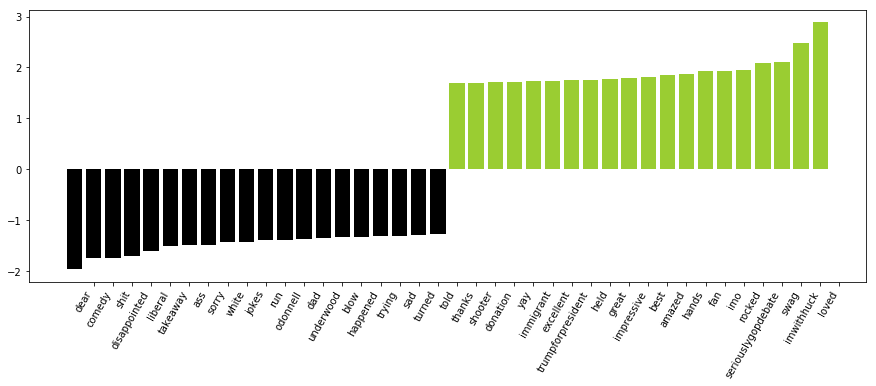

In [24]:
# Visualise the top features 
import matplotlib.pyplot as plt
def plot_coefficients(classifier, feature_names, top_features=20):
     coef = classifier.coef_.ravel()
     top_positive_coefficients = np.argsort(coef)[-top_features:]
     top_negative_coefficients = np.argsort(coef)[:top_features]
     top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
     # create plot
     plt.figure(figsize=(15, 5))
     colors = ["black" if c < 0 else "yellowgreen" for c in coef[top_coefficients]]
     plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
     feature_names = np.array(feature_names)
     plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha="right")
     plt.show()
 
plot_coefficients(model, cvec.get_feature_names())

------------------------------
By visual inspection we can certainly see that words that are indicators of positive sentiments make sense. And conversely the negative ones as well. Notice the word “Comedy” is one of the biggest indicator of a negative sentiment? I'll cover this in future post 

Now for the last thing to do, save the dataset of top 100 words for each negative and positive sentiments 

In [25]:
# Get the feature names from the vectoriser 
feature_names = np.array(cvec.get_feature_names())

# get the top 100 features and coeffficients 
top_positive_coefficients = np.argsort(clf.coef_.ravel())[-100:]
top_negative_coefficients = np.argsort(clf.coef_.ravel())[:100]

# Make the 2 datasets, one for positive words and one for negative 
top_negative_words = pd.DataFrame(feature_names[top_negative_coefficients])
top_positive_words = pd.DataFrame(feature_names[top_positive_coefficients])

# Save to disk 
top_negative_words.to_csv("Top100_Negative_words.csv",header=False,index=False)
top_positive_words.to_csv("Top100_Postive_words.csv",header=False,index=False)

# Check out the top 100 negative words 
top_negative_words

,0
0,dear
1,comedy
2,shit
3,disappointed
4,liberal
5,takeaway
6,ass
7,sorry
8,white
9,jokes


------------------------------
The End